## Zadanie - klasyczna detekcja obiektów

Celem tego zadania jest własnoręczne zbudowanie, debugowanie i przetestowanie przez Ciebie prostego pipeline'u do rozpoznawania obiektów opartego o klasyczne metody przetwarzania obrazów.

In [583]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from typing import Any, List
from enum import Enum
import numpy as np
import cv2

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Twoim zadaniem będzie zaproponowanie algorytmu detekcji, który przyjmie obraz wejściowy i wykryje na nim obiekty - poszczególne tabletki, zwracając informację o ich położeniach i gatunkach.
Reprezentacja tej informacji jest dowolna: pary koordynat (X,Y) środka obiektu, bounding boksy (XYHW), czy kontury - istotne jest jedynie, by liczba detekcji możliwie dobrze zgadzała się ze stanem faktycznym.

Zadanie ma charakter projektowy i nie jest podzielone na szczegółowo opisane podpunkty, ponieważ można do niego podejść na różne sposoby (czytaj dalej).

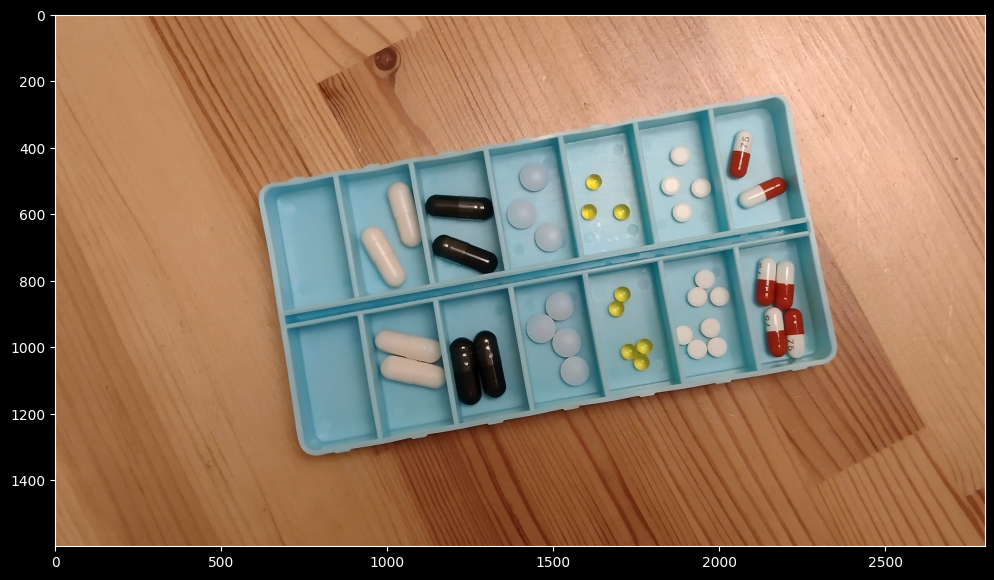

In [584]:
calib = cv2.imread('dane5/calib.png')
plt.subplots(1, 1, figsize=(12,8))[1].imshow(calib[..., ::-1]);

Występuje 6 klas obiektów; patrząc na organizer od lewej:

In [585]:
class PillType(Enum):
    PROBIO = 1    # duże białe kapsułki
    CARBON = 2    # duże czarne kapsułki
    KETO = 3      # niebieskie tabletki
    ESPU = 4      # małe żółte kapsułki
    BIOX = 5      # małe białe tabletki
    LINE = 6      # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)

Górny rząd zawiera łatwiejsze przykłady pojedynczych instancji, podczas gdy w rzędzie dolnym obiekty stykają się ze sobą, co utrudnia identyfikację.
Jak widzisz, nie wszystkie klasy są tak samo "wdzięczne" do wykrycia.
Nie próbuj zatem robić wszystkiego naraz - rekomendowane jest podejście sekwencyjne: najpierw zaimplementuj algorytm detekcji dla jednej klasy, przetestuj go i napraw, rozszerz o możliwość detekcji stykających się obiektów (_jak to zrobić?_), a dopiero potem podejmij kolejną klasę.

Wykorzystaj narzędzia poznane do tej pory (konwersje przestrzeni barw, binaryzację, detekcję krawędzi, etc.) by sprowadzić obraz do takiej postaci, w której detekcję interesujących obiektów będzie można wykonać za pomocą zwyczajnej ekstrakcji komponentów spójności - [`cv2.findContours`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0).
Wspomóż się operacjami morfologicznymi jeśli to potrzebne, i nie wahaj się stosować jakichkolwiek narzędzi jakie znajdziesz -
wszystkie chwyty są dozwolone, za wyjątkiem stosowania metod MLowych.

W zależności od wybranej reprezentacji wykrytych obiektów, zaimplementuj metodę wizualizacji wyników.

Nie usuwaj notebooka, w którym będziesz debugować algorytm!
Przyda się podczas rozmowy, jeśli zajdzie konieczność wyjaśnienia dlaczego twój algorytm popełnia błędy - możliwość pokazania krok po kroku wykonywanych operacji będzie istotna.

### Rozwiązanie:

In [586]:
def rhotheta2xy(line):
  # konwersja parametrów prostej w układzie rho-theta do odcinka w układzie kartezjańskim
  # wynik można użyć jako argumenty funkcji cv2.line
  rho, theta = line[0]
  a = np.cos(theta)
  b = np.sin(theta)
  x0 = a*rho
  y0 = b*rho
  x1 = int(x0 + 5000*(-b))
  y1 = int(y0 + 5000*(a))
  x2 = int(x0 - 5000*(-b))
  y2 = int(y0 - 5000*(a))
  return x1, y1, x2, y2

In [587]:
class Pill:
    """Output of object detection, represents a single instance"""
    def __init__(self, pill_type: PillType, location: Any):
        self.type = pill_type
        self.location = location

In [588]:
def detect_objects(image: np.ndarray, **kwargs) -> List[Pill]:
    # TU BĘDZIE TWOJA IMPLEMENTACJA DETEKTORA
    raise NotImplementedError

In [589]:
COLORMAP = {
    # RGB colorspace
    PillType.PROBIO: (255, 255, 255),
    PillType.CARBON: (0, 0, 0),
    PillType.KETO: (0, 0, 255),
    PillType.ESPU: (255, 255, 0),
    PillType.BIOX: (255, 0, 255),
    PillType.LINE: (255, 0, 0),
}

def display_objects(image: np.ndarray, objects: List[Pill]) -> None:
    # TU BĘDZIE TWOJA IMPLEMENTACJA METODY WIZUALIZACJI
    image = image.copy()
    # ...
    plt.imshow(image)

In [590]:
# found = detect_objects(calib)
# display_objects(calib, found)

### Test

Przetestuj swój algorytm na obrazie testowym `test.png` (lub `test_line.png`, jeśli podejmujesz się detekcji klasy LINE).
Gdzie pojawiają się problemy, skąd się biorą?
Jak można im zaradzić?

---

### Zadanie dodatkowe - dla chętnych

Cel: zliczenie wystąpień leków w poszczególnych komórkach organizera.

Wykorzystaj transformację Hougha do wykrycia linii oddzielających komórki organizera.
Dowolną poznaną metodą oblicz środki wykrytych obiektów.
Połącz obie informacje by określić zawartość każdej z komórek.

Wynik tej operacji powinien mieć formę struktury logicznej, pozwalającej na odpowiadanie na pytania np. "czy w 3 komórce dolnego rzędu są dwie sztuki `biox`?";
żadne szczegóły implementacyjne tej struktury nie są narzucone.

Jak poprzednio, zacznij od obrazu `calib`, a gotowy algorytm przetestuj na obrazach testowych.

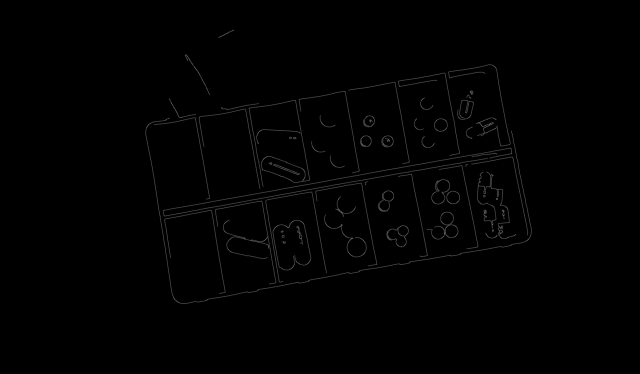

In [591]:
filtered_calib = cv2.GaussianBlur(calib, (11, 11), 0)

calib_edges = cv2.Canny(filtered_calib, 50, 150)

plt.figure(figsize=(8,8))
plt.imshow(calib_edges, cmap='gray')
plt.axis('off')
plt.show()

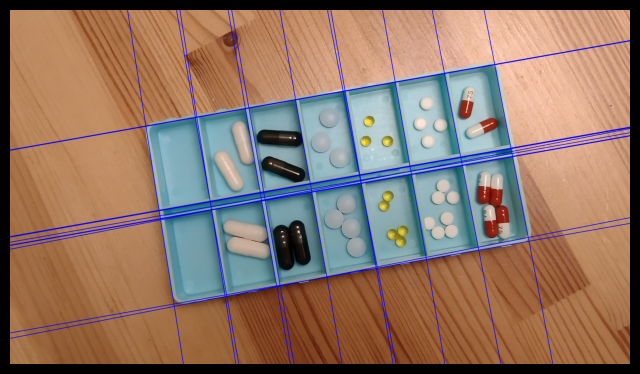

In [592]:
rho_pillbox = 1
theta_pillbox = np.pi / 180
threshold_pillbox = 200

lines_pillbox = cv2.HoughLines(calib_edges, rho_pillbox, theta_pillbox, threshold_pillbox)

pillbox_with_lines = calib.copy()

for line in lines_pillbox:
  x1, y1, x2, y2 = rhotheta2xy(line)
  cv2.line(pillbox_with_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.figure(figsize=(8,8))
plt.imshow(pillbox_with_lines[..., ::-1])
plt.axis('off')
plt.show()

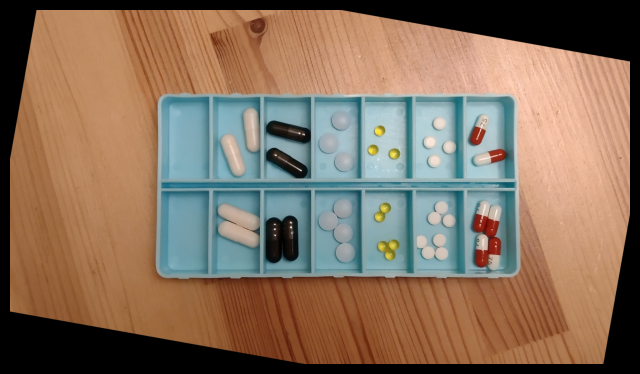

In [593]:
def get_rotation_angle(lines):
  angles = []
  for line in lines:
    rho, theta = line[0]
    # Convert theta to degrees
    angle = theta * 180 / np.pi
    # We're interested in horizontal lines (angles near 0 or 180)
    if angle < 45 or angle > 135:
      angles.append(angle)

  # Get the average angle
  mean_angle = np.mean(angles)
  if mean_angle > 90:
    return mean_angle - 180
  
  return mean_angle

# Get the rotation angle
angle = get_rotation_angle(lines_pillbox)

# Rotate the image
height, width = calib.shape[:2]
center = (width/2, height/2)
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated_image = cv2.warpAffine(calib, rotation_matrix, (width, height))

plt.figure(figsize=(8, 8))
plt.imshow(rotated_image[..., ::-1])
plt.axis('off')
plt.show()

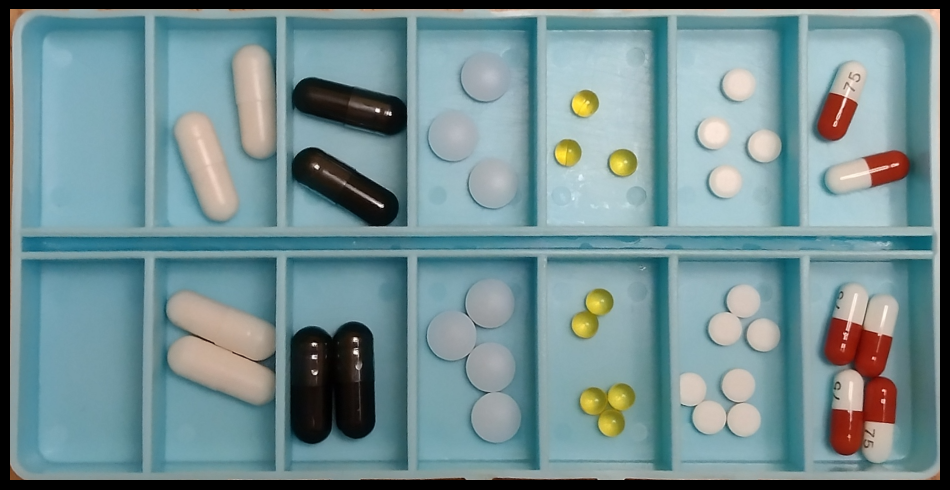

In [594]:
# After rotation, let's improve the pillbox detection and cropping
rotated_gray = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)

# Let's try using color to detect the blue box instead
hsv = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2HSV)
# Blue color range in HSV
lower_blue = np.array([90,50,50])
upper_blue = np.array([130,255,255])
blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Clean up the mask
kernel = np.ones((5,5), np.uint8)
blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_CLOSE, kernel)
blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_OPEN, kernel)

# Find contours of the pillbox
contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
pillbox_contour = max(contours, key=cv2.contourArea)

# Get a tighter bounding rect
x, y, w, h = cv2.boundingRect(pillbox_contour)

# Add a small padding to avoid cutting pills
padding = 10
x = max(0, x - padding)
y = max(0, y - padding)
w = min(rotated_image.shape[1] - x, w + 2*padding)
h = min(rotated_image.shape[0] - y, h + 2*padding)

# Crop the pillbox
calib_cropped = rotated_image[y:y+h, x:x+w]

# Debug visualization
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(calib_cropped, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [595]:
def display_image_and_histogram_hsv(image,  figsize=(12,4)):
  image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  h, s, v = cv2.split(image_hsv)

  fig, axs = plt.subplots(2, 3, figsize=figsize)
  axs[0, 0].imshow(h, cmap='gray')
  axs[0, 0].set_title('Hue')
  axs[0, 0].axis('off')
  axs[0, 1].imshow(s, cmap='gray')
  axs[0, 1].set_title('Saturation')
  axs[0, 1].axis('off')
  axs[0, 2].imshow(v, cmap='gray')
  axs[0, 2].set_title('Value')
  axs[0, 2].axis('off')
  axs[1, 0].hist(h.ravel(), bins=256, color='gray')
  axs[1, 1].hist(s.ravel(), bins=256, color='gray')
  axs[1, 2].hist(v.ravel(), bins=256, color='gray')
  plt.tight_layout()
  plt.show()

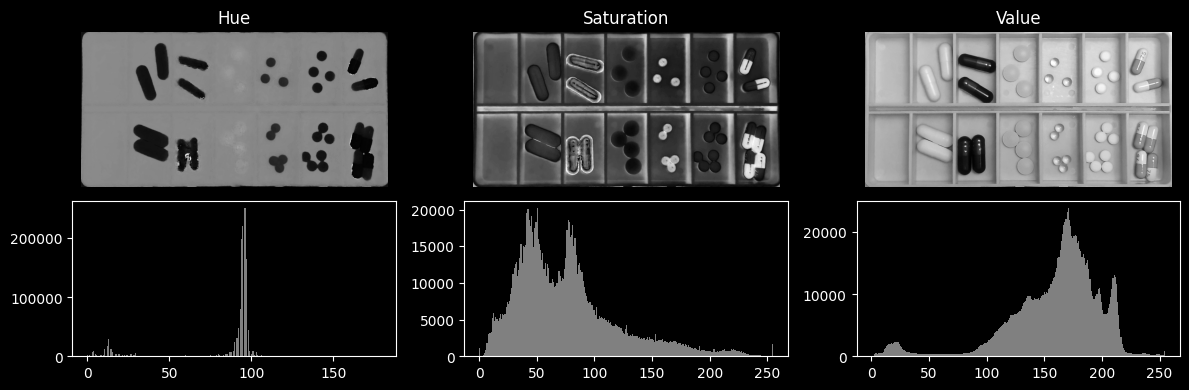

In [596]:
display_image_and_histogram_hsv(calib_cropped)

In [597]:
hsv = cv2.cvtColor(calib_cropped, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)

h_blurred = cv2.GaussianBlur(h, (5,5), 0)

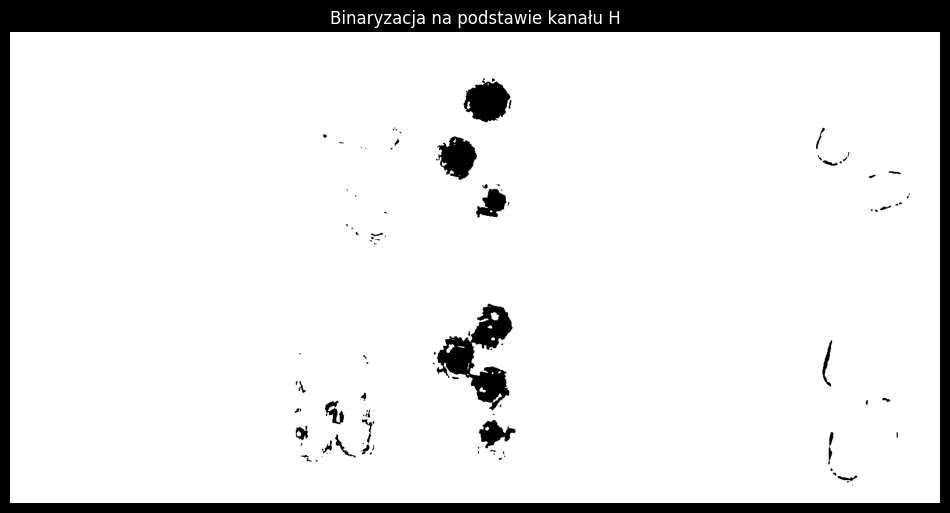

In [598]:
threshold = 100
_, h_binary = cv2.threshold(h_blurred, threshold, 255, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(12,8))
plt.imshow(h_binary, cmap='gray')
plt.title('Binaryzacja na podstawie kanału H')
plt.axis('off')
plt.show()

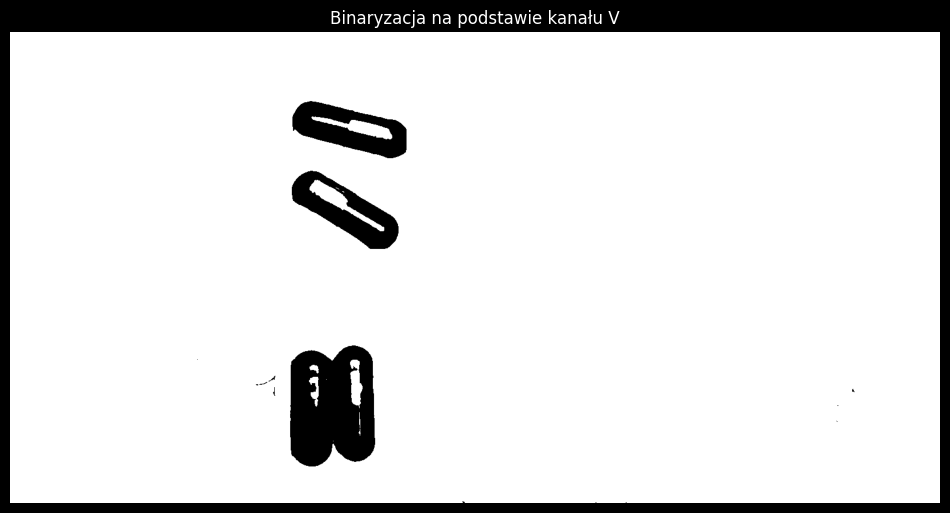

In [599]:
v_blurred = cv2.GaussianBlur(v, (5,5), 0)
threshold = 50
_, v_binary = cv2.threshold(v_blurred, threshold, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(12,8))
plt.imshow(v_binary, cmap='gray')
plt.title('Binaryzacja na podstawie kanału V')
plt.axis('off')
plt.show()

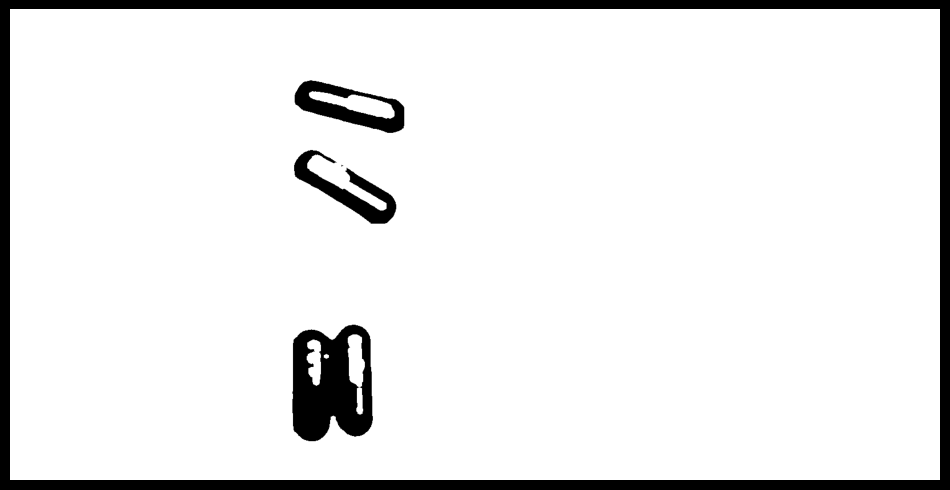

In [600]:
# distilation
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

v_binary_eroded = cv2.morphologyEx(v_binary, cv2.MORPH_DILATE, kernel, iterations=2)

plt.figure(figsize=(12,8))
plt.imshow(v_binary_eroded, cmap='gray')
plt.axis('off')
plt.show()


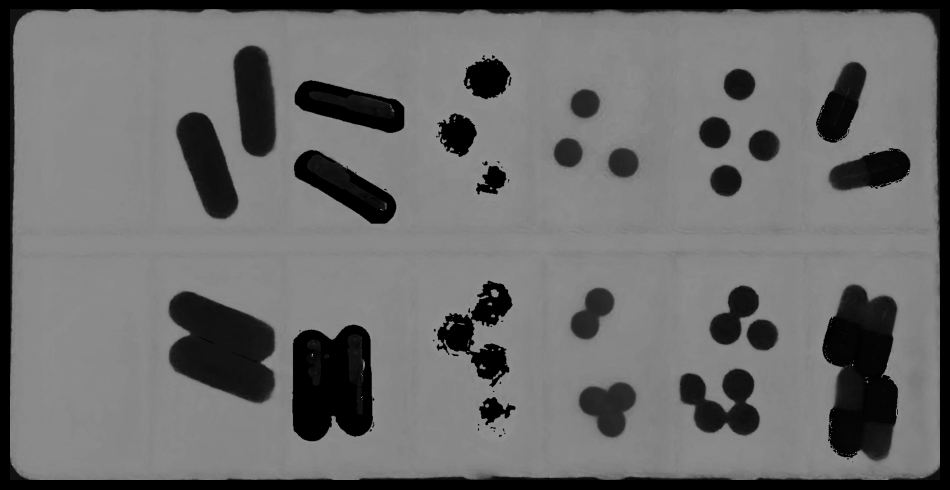

In [601]:
# add black parts of h_binary to h_blurred
h[h_binary == 0] = 0
h[v_binary_eroded == 0] = 0

plt.figure(figsize=(12,8))
plt.imshow(h, cmap='gray')
plt.axis('off')
plt.show()

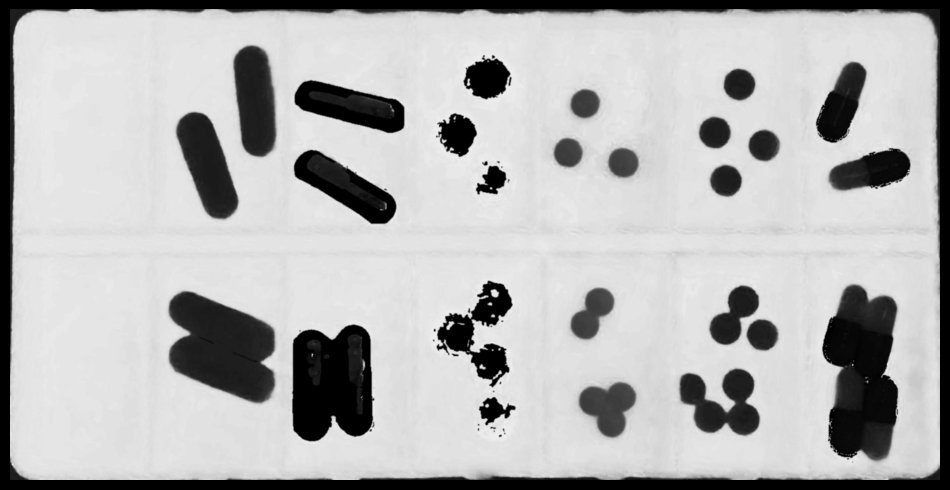

In [602]:
h_blurred = cv2.GaussianBlur(h, (3,3), 0)

plt.figure(figsize=(12,8))
plt.imshow(h_blurred, cmap='gray')
plt.axis('off')
plt.show()

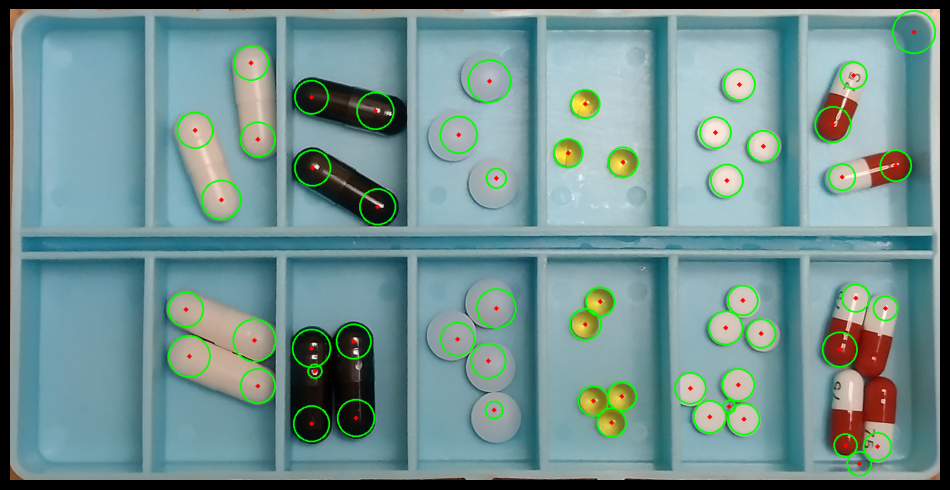

In [603]:
circles = cv2.HoughCircles(
  h_blurred,
  cv2.HOUGH_GRADIENT,
  dp=1,
  minDist=30,
  param1=30,
  param2=15,
  minRadius=10,
  maxRadius=40
)

circles = np.uint16(np.around(circles))

calib_circles = calib_cropped.copy()
for i in circles[0,:]:
  cv2.circle(calib_circles,(i[0],i[1]),i[2],(0,255,0),2)
  cv2.circle(calib_circles,(i[0],i[1]),2,(0,0,255),3)
 
plt.figure(figsize=(12,8))
plt.imshow(calib_circles[..., ::-1])
plt.axis('off')
plt.show()

Unknown pill color: H=13, S=50, V=192. At location: (310, 526)
Unknown pill color: H=11, S=79, V=45. At location: (528, 596)
Unknown pill color: H=11, S=93, V=22. At location: (602, 716)
Unknown pill color: H=14, S=63, V=53. At location: (530, 152)


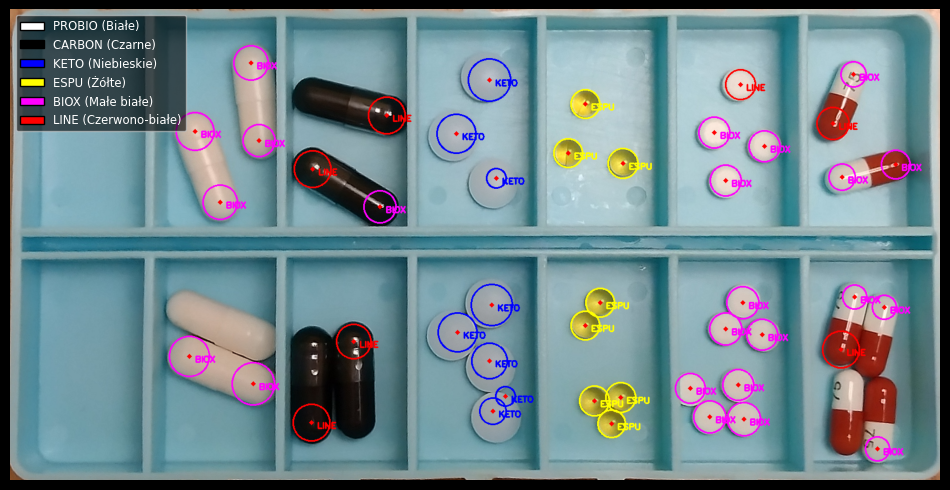

In [604]:


# Definicja klas tabletek
class PillType(Enum):
    PROBIO = 1    # duże białe kapsułki
    CARBON = 2    # duże czarne kapsułki
    KETO = 3      # niebieskie tabletki
    ESPU = 4      # małe żółte kapsułki
    BIOX = 5      # małe białe tabletki
    LINE = 6      # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)

# Definicja kolormap dla wizualizacji (w formacie BGR)
COLORMAP = {
    PillType.PROBIO: (255, 255, 255),     # Białe
    PillType.CARBON: (0, 0, 0),           # Czarne
    PillType.KETO: (255, 0, 0),           # Niebieskie (BGR)
    PillType.ESPU: (0, 255, 255),         # Żółte (BGR)
    PillType.BIOX: (255, 0, 255),         # Małe białe (BGR)
    PillType.LINE: (0, 0, 255),           # Czerwone (BGR)
}

class Pill:
    def __init__(self, pill_type: PillType, center: Any, radius: int):
        self.type = pill_type
        self.center = center
        self.radius = radius
        

def detect_objects(image: np.ndarray, debug: bool = False) -> List[Pill]:
    detected_pills = []
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    r, g, b = cv2.split(rgb)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h_channel, s_channel, v_channel = cv2.split(hsv)

    h_blurred = cv2.GaussianBlur(h_channel, (5, 5), 0)
    _, h_binary = cv2.threshold(h_blurred, 100, 255, cv2.THRESH_BINARY_INV)
    h_channel[h_binary == 0] = 0

    v_blurred = cv2.GaussianBlur(v_channel, (5, 5), 0)
    _, v_binary = cv2.threshold(v_blurred, 50, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    v_binary_eroded = cv2.morphologyEx(v_binary, cv2.MORPH_DILATE, kernel, iterations=2)
    h_channel[v_binary_eroded == 0] = 0
    
    h_blurred = cv2.GaussianBlur(h_channel, (7,7), 0)
    
    circles = cv2.HoughCircles(
        h_blurred,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=30,
        param1=30,
        param2=15,
        minRadius=12,
        maxRadius=40
    )
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            center = (i[0], i[1])
            radius = i[2]
            
            # Pobierz kolor piksela w centrum okręgu
            color = image[center[1], center[0]]
            color_hsv = cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_BGR2HSV)[0][0]
            h, s, v = color_hsv
            gray = np.mean(color)
            
            # Klasyfikacja na podstawie koloru
            if 90 <= h <= 130:  # Niebieskie tabletki
                pill_type = PillType.KETO

            elif 20 <= h <= 30 and s > 100:  # Żółte kapsułki
                pill_type = PillType.ESPU
            
            elif (0 <= h <= 10) or (160 <= h <= 180) and s > 200:  # Czerwono-białe kapsułki
                pill_type = PillType.LINE
            
            elif h < 50 and s < 50:  # Białe tabletki
                pill_type = PillType.BIOX
            
            elif v < 20 and s < 20:  # Czarne kapsułki
                pill_type = PillType.CARBON
            
            else:
                print(f'Unknown pill color: H={h}, S={s}, V={v}. At location: {center}')
                continue
            
            detected_pills.append(Pill(pill_type, center, radius))
    
    return detected_pills

def display_objects(image: np.ndarray, objects: List[Pill]) -> None:
    image_display = image.copy()
    for pill in objects:
        if pill.type in PillType:
            # Rysowanie okręgów
            cv2.circle(image_display, pill.center, pill.radius, COLORMAP[pill.type], 2)
            cv2.circle(image_display, pill.center, 2, (0, 0, 255), 3)
            # Dodawanie etykiety
            cv2.putText(
                image_display, 
                pill.type.name, 
                (pill.center[0]+10, pill.center[1]+10), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.5, 
                COLORMAP[pill.type], 
                2
            )
    
    # Tworzenie legendy (konwersja BGR na RGB)
    legend_elements = [
        Patch(facecolor=np.array(COLORMAP[PillType.PROBIO])[::-1]/255,  edgecolor='k', label='PROBIO (Białe)'),
        Patch(facecolor=np.array(COLORMAP[PillType.CARBON])[::-1]/255,  edgecolor='k', label='CARBON (Czarne)'),
        Patch(facecolor=np.array(COLORMAP[PillType.KETO])[::-1]  /255,  edgecolor='k', label='KETO (Niebieskie)'),
        Patch(facecolor=np.array(COLORMAP[PillType.ESPU])[::-1]  /255,  edgecolor='k', label='ESPU (Żółte)'),
        Patch(facecolor=np.array(COLORMAP[PillType.BIOX])[::-1]  /255,  edgecolor='k', label='BIOX (Małe białe)'),
        Patch(facecolor=np.array(COLORMAP[PillType.LINE])[::-1]  /255,  edgecolor='k', label='LINE (Czerwono-białe)'),
    ]
    
    plt.figure(figsize=(12,8))
    plt.imshow(cv2.cvtColor(image_display, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.legend(handles=legend_elements, loc='upper left', fontsize='small', framealpha=0.6)
    plt.show()

found = detect_objects(calib_cropped, debug=True)
display_objects(calib_cropped, found)